Task 7 - Walmart Store Sales Analysis

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [42]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
url ="/content/drive/My Drive/elevvo internship/task6/Walmart.csv"
df = pd.read_csv(url)
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [44]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")
df = df.sort_values(["Store","Date"]).reset_index(drop=True)

In [45]:
print("\nMissing Values:")
print(df.isnull().sum())



Missing Values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [46]:
def add_store_lags(group, target_col="Weekly_Sales"):
    group = group.sort_values("Date")
    group["lag_1"]  = group[target_col].shift(1)
    group["lag_4"]  = group[target_col].shift(4)      # ~monthly (weekly data)
    group["lag_13"] = group[target_col].shift(13)     # ~quarterly
    group["roll_mean_4"]  = group[target_col].shift(1).rolling(4).mean()
    group["roll_mean_13"] = group[target_col].shift(1).rolling(13).mean()
    return group

df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"]  = df["Date"].dt.isocalendar().week.astype(int)

df = df.groupby("Store", group_keys=False).apply(add_store_lags)

# Drop early rows with NaNs from lags/rolls
df = df.dropna(subset=["lag_1","lag_4","lag_13","roll_mean_4","roll_mean_13"]).reset_index(drop=True)


/tmp/ipython-input-4094065575.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Store", group_keys=False).apply(add_store_lags)


In [47]:
split_date = df["Date"].quantile(0.8)  # last 20% for test
train = df[df["Date"] < split_date].copy()
test  = df[df["Date"] >= split_date].copy()

feature_cols_num = [
    "Holiday_Flag","Temperature","Fuel_Price","CPI","Unemployment",
    "Year","Month","Week","lag_1","lag_4","lag_13","roll_mean_4","roll_mean_13"
]
feature_cols_cat = ["Store"]  # one-hot

X_train = train[feature_cols_num + feature_cols_cat]
y_train = train["Weekly_Sales"].values
X_test  = test[feature_cols_num + feature_cols_cat]
y_test  = test["Weekly_Sales"].values

In [48]:
# 4) Baseline model: Linear Regression (with OneHot for Store)
# -----------------------------
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
        ("num", "passthrough", feature_cols_num),
    ]
)

linreg = Pipeline([
    ("prep", pre),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
pred_lin = linreg.predict(X_test)

rmse_lin = np.sqrt(mean_squared_error(y_test, pred_lin))
mae_lin  = mean_absolute_error(y_test, pred_lin)
print(f"[LinearRegression] RMSE={rmse_lin:.2f}  MAE={mae_lin:.2f}")


[LinearRegression] RMSE=73161.06  MAE=55917.30


In [49]:
# 5) XGBoost (bonus model)
# -----------------------------
xgb = Pipeline([
    ("prep", pre),
    ("model", XGBRegressor(
        n_estimators=400,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
mae_xgb  = mean_absolute_error(y_test, pred_xgb)
print(f"[XGBoost]         RMSE={rmse_xgb:.2f}  MAE={mae_xgb:.2f}")


[XGBoost]         RMSE=54038.46  MAE=37653.63


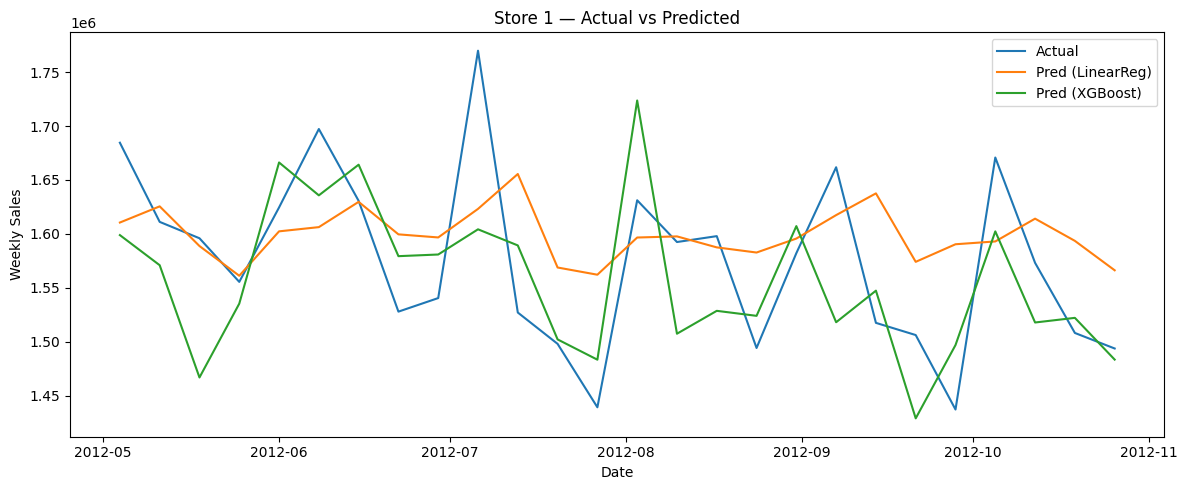

In [50]:
# 6) Plot Actual vs Predicted over time (one store for clarity)
# -----------------------------
sample_store = test["Store"].mode().iloc[0]  # pick most frequent in test
mask = test["Store"] == sample_store

dates_plot = test.loc[mask, "Date"]
actual_plot = test.loc[mask, "Weekly_Sales"].values
pred_lin_plot = pred_lin[mask.values]
pred_xgb_plot = pred_xgb[mask.values]

plt.figure(figsize=(12,5))
plt.plot(dates_plot, actual_plot, label="Actual")
plt.plot(dates_plot, pred_lin_plot, label="Pred (LinearReg)")
plt.plot(dates_plot, pred_xgb_plot, label="Pred (XGBoost)")
plt.xlabel("Date"); plt.ylabel("Weekly Sales"); plt.title(f"Store {sample_store} — Actual vs Predicted")
plt.legend(); plt.tight_layout(); plt.show()

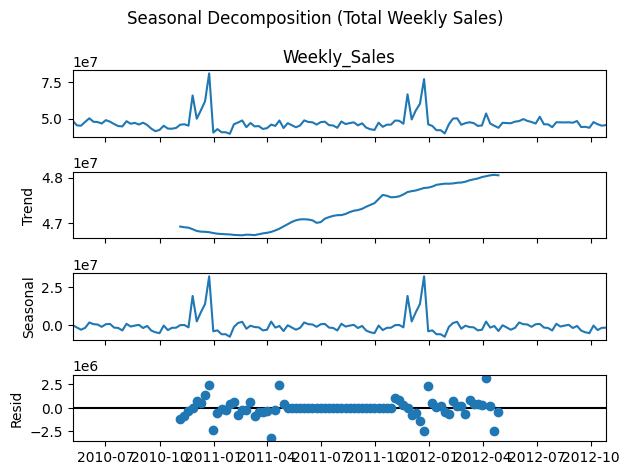

In [51]:
# 7) Extra bonus: rolling averages + seasonal decomposition (quick peek)
#    (comment out if statsmodels not installed)
# -----------------------------
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    # aggregate to total weekly sales (all stores) for decomposition view
    agg = df.groupby("Date", as_index=False)["Weekly_Sales"].sum().sort_values("Date")
    agg = agg.set_index("Date")
    result = seasonal_decompose(agg["Weekly_Sales"], model="additive", period=52)  # weekly data
    result.plot()
    plt.suptitle("Seasonal Decomposition (Total Weekly Sales)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Seasonal decomposition skipped:", e)